## Plot Benchmark Data
This python notebook uses `matplotlib` and `pandas`.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
df = pd.read_csv('data.csv')
selections = {
    'hdfs read direct' : (df['filesystem']=='hdfs')&(df['cp_to_scratch']==False)&(df['process']==True),
    'hdfs cp to scratch then read' : (df['filesystem']=='hdfs')&(df['cp_to_scratch']==True)&(df['process']==True),
#    'local read direct' : (df['filesystem']=='zfs')&(df['cp_to_scratch']==False)&(df['process']==True),
    'local cp to scratch then read' : (df['filesystem']=='zfs')&(df['cp_to_scratch']==True)&(df['process']==True)
}

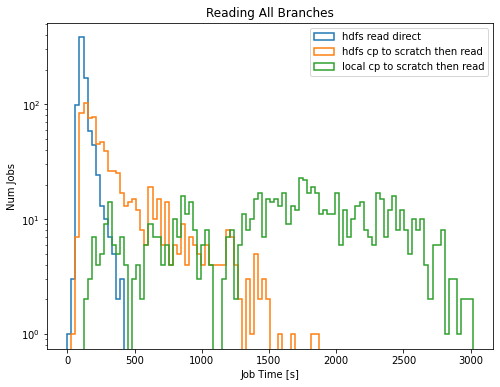

In [8]:
plt.figure(figsize=(8,6))
max_time = np.max(df[df['branches']==-1]['time'])
for name, sl in selections.items() :
    plt.hist(df[sl&(df['branches']==-1)]['time'],label=name, histtype='step',lw=1.5,bins=100,range=(0.,max_time))
plt.xlabel('Job Time [s]')
plt.ylabel('Num Jobs')
plt.legend()
plt.yscale('log')
plt.title('Reading All Branches')
plt.show()

In [19]:
df[selections['hdfs cp to scratch then read']].mean() / 30

size             8.760356e+07
time             1.298743e+01
cp_to_scratch    3.333333e-02
branches        -3.333333e-02
process          3.333333e-02
dtype: float64

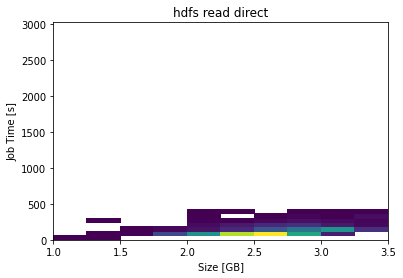

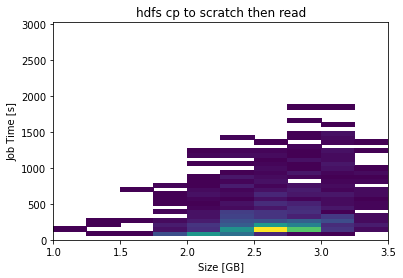

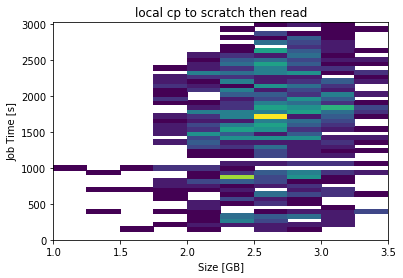

In [9]:
for name, sl in selections.items() :
    sld = df[sl&(df['branches']==-1)]
    plt.hist2d(sld['size']/1e9,sld['time'], cmin = 1, bins=(10,50), range=((1.,3.5),(0.,max_time)))
    plt.xlabel('Size [GB]')
    plt.ylabel('Job Time [s]')
    plt.title(name)
    plt.show()

## Qualitative Notes
- HDFS remote read is only slightly faster (in time) compared to ZFS cp to scratch then read
- HDFS jobs fail much more regularly due to ROOT's inability to open the file on HDFS, resubmission seems to fix the issue but is annoying for the user
- Copying output files to HDFS also fails more regularly and requires the user to implement a [a special copying function](https://github.com/UMN-CMS/ldmx-scripts/blob/4f7b2f532beea31533b5cf77084974f3bfe56694/batch/run_ldmx.sh#L63-L116) which performs multiple copy attempts and checks that the full file was actually copied

# Subset of Branches
For a more realistic analysis of analysis jobs, the user expects to only read a subset of the branches available. A reasonable upper limit for the number of branches accessed in a given analysis job is about 50 (out of the hundreds of branches available), so I chose to just choose that nice round number.

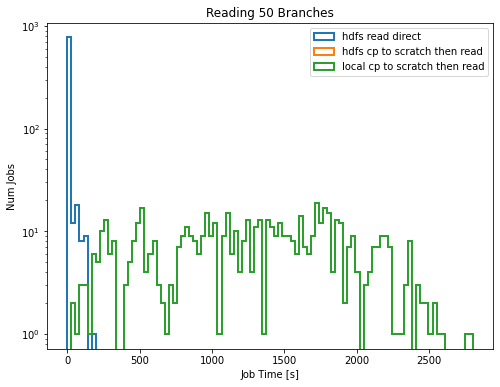

In [10]:
plt.figure(figsize=(8,6))
max_time = np.max(df[df['branches']==50]['time'])
for name, sl in selections.items() :
    plt.hist(df[sl&(df['branches']==50)]['time'],label=name, histtype='step',lw=2.,bins=100,range=(0.,max_time))
plt.xlabel('Job Time [s]')
plt.ylabel('Num Jobs')
plt.yscale('log')
plt.legend()
plt.title('Reading 50 Branches')
plt.show()

## No Processing Runs
The runs below are for just performing the copy to the worker node and then performing no processing on the file. This is a good test of the fastest the copy-to-scratch style analyses can be.

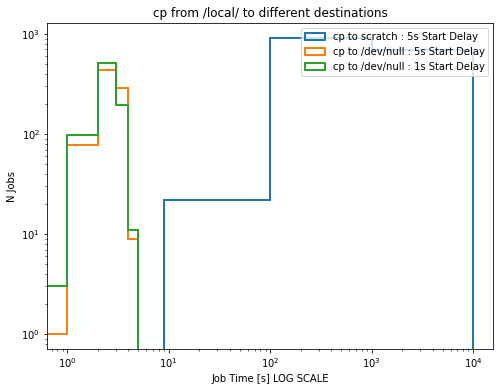

In [5]:
devnull_df = pd.read_csv('cp_dev_null.csv')
plt.figure(figsize=(8,6))
bins=np.append(np.arange(0.,10.,1.),[100.,1000.,10000.])
plt.hist(np.clip(df[df['cp_to_scratch']==True]['time'],0.,bins[-1]),label='cp to scratch : 5s Start Delay',
         histtype='step',lw=2.,bins=bins)
plt.hist(devnull_df[devnull_df['delay']==5]['time'],label='cp to /dev/null : 5s Start Delay',
         histtype='step',lw=2.,bins=bins)
plt.hist(devnull_df[devnull_df['delay']==1]['time'],label='cp to /dev/null : 1s Start Delay',
         histtype='step',lw=2.,bins=bins)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N Jobs')
plt.xlabel('Job Time [s] LOG SCALE')
plt.title('cp from /local/ to different destinations')
plt.legend()
plt.show()